# Part 1: Depth Estimation

## Task

"Implement any model and training + evaluation script on NYU Depth V2 (available in TFDS → https://www.tensorflow.org/datasets/catalog/nyu_depth_v2, so TensorFlow is probably better way to complete this assessment; but if you would prefer PyTorch, feel free to pick any Depth Estimation dataset that you may find). The model architecture should not be sophisticated or very complex, so feel free to pick any tiny architecture that should work from your point of view. The same for the training config and optimizer to use, but please demonstrate how to use different optimizers and callbacks, in particular learning rate scheduler."

## Approach

### Model

I chose [PyTorch Lightning](https://github.com/Lightning-AI/pytorch-lightning) for this task. Lightning comes with several advantages over unstructured PyTorch (from their repo):

* Models become hardware agnostic
* Code is clear to read because engineering code is abstracted away
* Easier to reproduce
* Make fewer mistakes because lightning handles the tricky engineering
* Keeps all the flexibility (LightningModules are still PyTorch modules), but removes a ton of boilerplate
* Lightning has dozens of integrations with popular machine learning tools.
* Minimal running speed overhead (about 300 ms per epoch compared with pure PyTorch).


For the "use different optimizers and callbacks, in particular learning rate scheduler" parts of the task in my experience often there's not a huge difference between the top choices. I provide a simple choice between three basic configurations in this notebook. If I wanted to work through a larger search space for optimal results I'd proceed similar to hyperparameter search experiments:

In a previous audio classification project I came upon [this very insightful report](https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc). The report shows how various (mostly audio-specific) hyperparameters (hop_length, win_length, n_mels, n_fft, ..., n_epochs, batch_size) have been tested strategically. wandb.ai offers a simple and straightforward way to track such experiments.

## Instructions to follow along

To execute this notebook you can easily set up your own virtual environment, download the trained model weights (if you want to skip the training) and execute the following commands. It has been tested with Python 3.11 on macOS 14.3 but should work on any recent Linux + macOS system.

    python3.11 -m venv .venv
    source .venv/bin/activate
    pip install -r requirements.txt
    jupyter notebook

The model weights are currently stored in the Google Cloud (due to GitHub file size restrictions). [Download them here](https://drive.google.com/file/d/1ZziRkV1A6CNtlrJkSK45yJv0mf5_Hu5g/view?usp=drive_link) and place them under *lightning_logs/version_32/checkpoints/*

### Dataset

Using the 🤗 HuggingFace version of NYU-Depth V2 dataset.

In [1]:
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
from torchvision.transforms import v2
from lightning.pytorch import loggers as pl_loggers
import lightning as L
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import dataclasses
from typing import List
from includes.metrics import DepthMetrics, evaluate_depth_metrics

In [2]:
cmap = plt.cm.viridis

ds = load_dataset("sayakpaul/nyu_depth_v2", trust_remote_code=True)

In [3]:
ds['train'].features

{'image': Image(decode=True, id=None),
 'depth_map': Image(decode=True, id=None)}

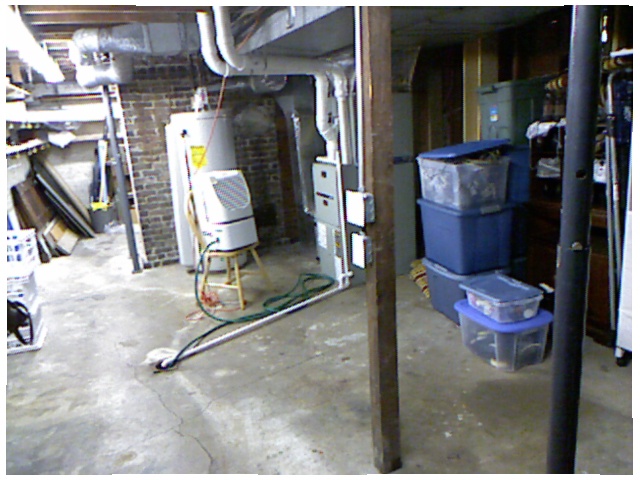

In [4]:
image, depth_mask = ds['train'][42].values()
image

In [5]:
image.size

(640, 480)

In [6]:
depth_mask_np = np.array(depth_mask)
depth_mask_np.min(), depth_mask_np.max(), depth_mask_np.mean(), depth_mask_np.std()

(0.0, 7.95988, 3.503069, 1.5978205)

In [7]:
RESIZED_SIZES = (224, 224)

# Only basic transforms for assessment project, different for mask and image
transforms_mask = v2.Compose([
    # v2.Identity(),
    v2.ToImage(),
    v2.CenterCrop(size=480),
    v2.Resize(RESIZED_SIZES, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    ]
)

In [8]:
import copy
transforms_image = copy.deepcopy(transforms_mask)
transforms_image.add_module("normalize", v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

In [9]:
def my_transforms(examples):
    examples['image'] = transforms_image(examples['image'])
    examples['depth_map'] = transforms_mask(examples['depth_map'])
    return examples

In [10]:
depth_mask_transformed = transforms_mask(depth_mask)
depth_mask_transformed
# depth_mask_transformed.min(), depth_mask_transformed.max(), depth_mask_transformed.mean(), depth_mask_transformed.std()

Image([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.3439, 2.3510, 2.3519,  ..., 1.3660, 1.3141, 1.2774],
        [2.3587, 2.3718, 2.3724,  ..., 1.3988, 1.3325, 1.2854],
        [2.3702, 2.3724, 2.3724,  ..., 1.3988, 1.3325, 1.2854]]], )

In [11]:
def colored_depthmap(depth, d_min=None, d_max=None):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C


def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

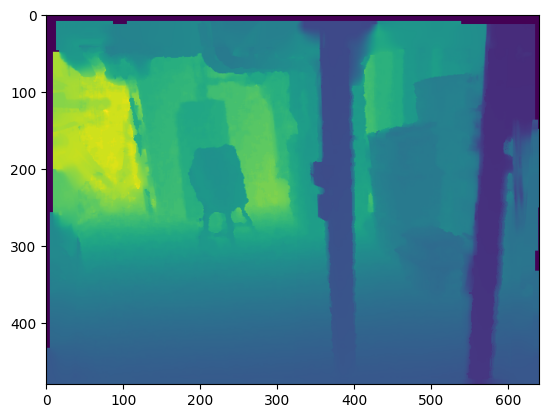

In [12]:
plt.imshow(colored_depthmap(depth_mask).astype(np.uint8))

In [13]:
type(transforms_mask(depth_mask))

torchvision.tv_tensors._image.Image

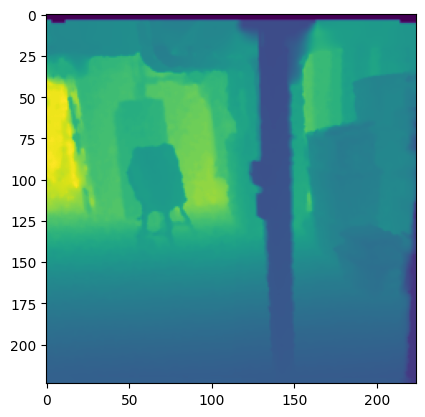

In [14]:
# Issue has to do with TVTensors from transforms.v2.ToImage
plt.imshow(np.asarray(transforms_mask(depth_mask)).squeeze())

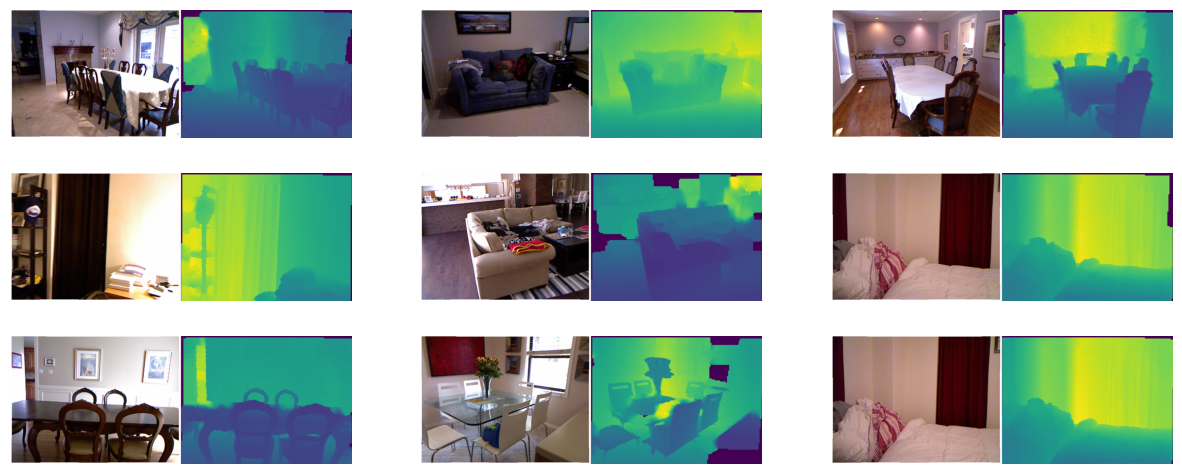

In [15]:
train_set = ds['train']
random_indices = np.random.choice(len(train_set), 9).tolist()

plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    image_viz = merge_into_row(
        train_set[idx]["image"], train_set[idx]["depth_map"]
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [16]:
# Splitting the training data into training + validation (for training) so we can keep the 654 items for testing
# using a tiny split for quick evaluation (1/100th of dataset size)
dst = ds.with_transform(my_transforms) # create new dataset which uses transforms
ds_train, ds_validation, _ = random_split(dst["train"], (0.0085, 0.0015, 0.99)) # use built-in method in datasets.Dataset.train_test_split in future
ds_test = dst['validation']

In [17]:
len(ds_train), len(ds_validation), len(ds_test)

(405, 71, 654)

### Tasks:

- [x] build UNet with right input + output for dataset; (adaptation of [monodepth-dev](https://github.com/karasawatakumi/monodepth-dev))
- [x] decide on loss function
- [x] transforms (use torchvision transforms v2 for improved speed)
- [x] demonstration of different callbacks (Optimizer, LR Scheduler, Tensorboard logging ([on-validation-epoch end callback](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#on-validation-epoch-end)))

### Loss graph (from Tensorboard, MPS accelerator)

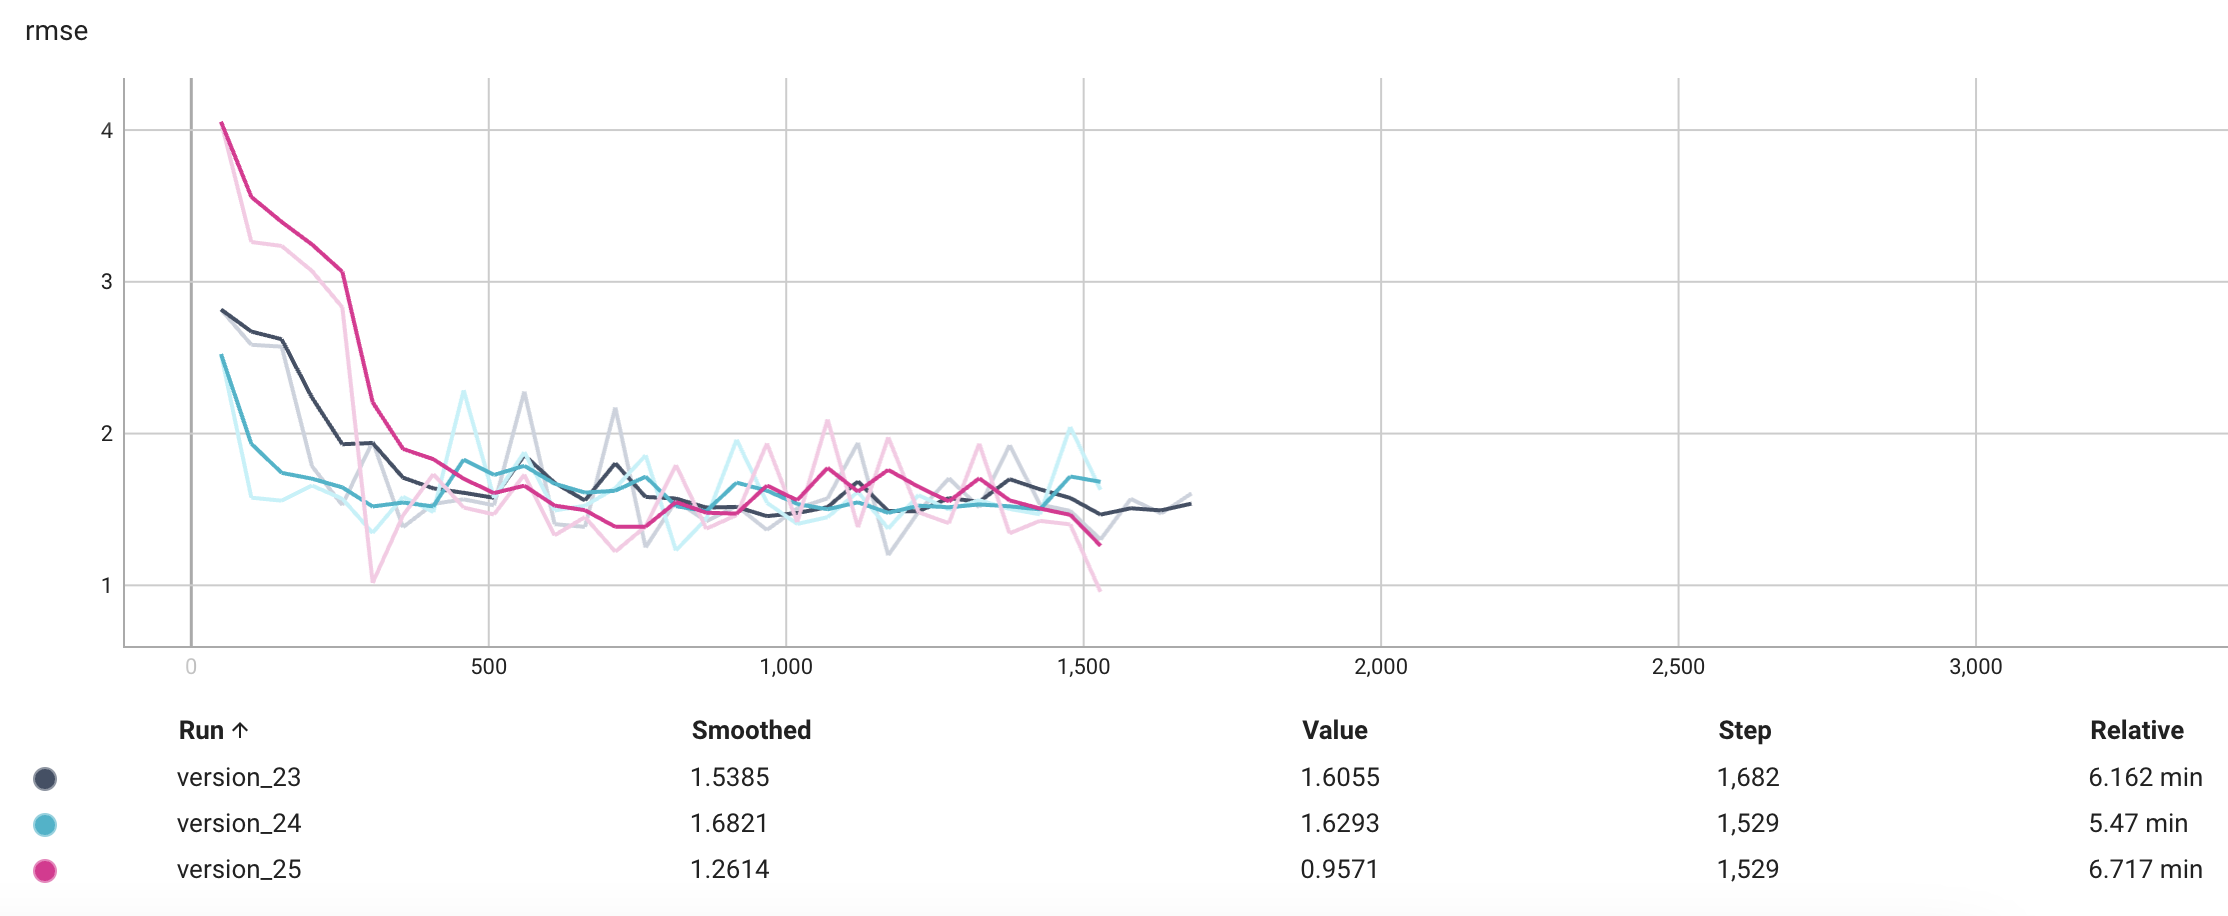

* version_23 + 24: SGD + ExponentialLR (choice 0)
* versio 25: AdamW + OneCycleLR (choice 2)

In [18]:
OPTIM_LR_SCHED_CHOICE=2  # choice out of 3 sample combinations, see configure_optimizers function

In [19]:
# copied from https://github.com/JunjH/Revisiting_Single_Depth_Estimation

class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.edge_conv = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=False)
        edge_kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        edge_ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        edge_k = np.stack((edge_kx, edge_ky))

        edge_k = torch.from_numpy(edge_k).float().view(2, 1, 3, 3)
        self.edge_conv.weight = nn.Parameter(edge_k)

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = self.edge_conv(x)
        out = out.contiguous().view(-1, 2, x.size(2), x.size(3))

        return out

## Train

In [20]:
NUM_EPOCHS=30
LR=1e-3

class DepthUNet(L.LightningModule):
    """Flexible small implementation with a small backbone (mobilenet-v2)"""
    
    def __init__(self):
        super().__init__()
        self.cos = nn.CosineSimilarity(dim=1, eps=0)
        self.get_gradient = Sobel()
        self.net = smp.Unet(encoder_name='mobilenet_v2', encoder_weights='imagenet', in_channels=3, classes=1)

    def forward(self, x):
        print("in forward")
        image = x
        output = self.net(image)
        output = F.interpolate(output, size=[RANDOM_RESIZED_SIZES[0], RANDOM_RESIZED_SIZES[1]],
                               mode='bilinear', align_corners=True)
        return output

    def training_step(self, x, idx):
        """Simple loss functions don't do it for the monocular depth estimation task, so combinations
        of different losses seem to work best. This one is from:
        https://github.com/JunjH/Revisiting_Single_Depth_Estimation/blob/master/train.py"""

        image, depth = x['image'], x['depth_map']

        # forward
        output = self.net(image)

        # loss: depth
        loss_depth = torch.log(torch.abs(output - depth) + 0.5).mean()

        # loss: grad
        depth_grad = self.get_gradient(depth)
        output_grad = self.get_gradient(output)
        depth_grad_dx = depth_grad[:, 0, :, :].contiguous().view_as(depth)
        depth_grad_dy = depth_grad[:, 1, :, :].contiguous().view_as(depth)
        output_grad_dx = output_grad[:, 0, :, :].contiguous().view_as(depth)
        output_grad_dy = output_grad[:, 1, :, :].contiguous().view_as(depth)

        loss_dx = torch.log(torch.abs(output_grad_dx - depth_grad_dx) + 0.5).mean()
        loss_dy = torch.log(torch.abs(output_grad_dy - depth_grad_dy) + 0.5).mean()

        # loss: normal
        ones = torch.ones(depth.size(0), 1, depth.size(2), depth.size(3), requires_grad=True).type_as(image)
        depth_normal = torch.cat((-depth_grad_dx, -depth_grad_dy, ones), 1)
        output_normal = torch.cat((-output_grad_dx, -output_grad_dy, ones), 1)

        loss_normal = torch.abs(1 - self.cos(output_normal, depth_normal)).mean()

        # loss
        loss = loss_depth \
            + 1 * (loss_dx + loss_dy) \
            + 1 * loss_normal

        self.log_dict({'l_d': loss_depth, 'l_g': loss_dx + loss_dy, 'l_n': loss_normal},
                      prog_bar=True)
        return loss

    def validation_step(self, x, idx):
        image, depth = x['image'], x['depth_map']

        # forward
        output = self.net(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2), depth.size(3)],
                                                 mode='bilinear', align_corners=True)

        # calc metrics
        d_metrics: DepthMetrics = evaluate_depth_metrics(output, depth)

        self.log_dict(dataclasses.asdict(d_metrics))

        self.validation_step_outputs = d_metrics

        return d_metrics.mse  # for rmse calculation

    def on_validation_epoch_end(self):
        self.log('rmse', np.sqrt(self.validation_step_outputs.mse))


    def predict_step(self, x, idx, dataloader_idx=0):
        return self.net(x)


    def configure_optimizers(self):
        """Here the different optimizers and LR schedulers can be configured.
        
        As per the requirement of the task I demonstrate the use of different optims and LR schedulers
        in this section. To switch between the 3 choices I have pre-configured, just change the choice 
        variable.
        """

        # optims
        sgd = torch.optim.SGD(self.parameters(), lr=LR, momentum=0.9)
        adamw = torch.optim.AdamW(self.parameters(), lr=LR)

        # LR schedulers
        exp = torch.optim.lr_scheduler.ExponentialLR
        onecycle = torch.optim.lr_scheduler.OneCycleLR
        

        choices = [
            {'optimizer': sgd,
             'lr_scheduler': exp(sgd, 0.9)},
            {'optimizer': adamw,
             'lr_scheduler': exp(adamw, 0.9)},
            {'optimizer': adamw,
             'lr_scheduler': onecycle(adamw, LR, total_steps=NUM_EPOCHS)}
        ]

        choice = choices[OPTIM_LR_SCHED_CHOICE]
        
        return choice

In [21]:
depth_net = DepthUNet()
tensorboard = pl_loggers.TensorBoardLogger(save_dir="")
trainer = L.Trainer(default_root_dir="checkpoints/", logger=tensorboard, max_epochs=NUM_EPOCHS) # limit_train_batches=0.05, limit_val_batches=0.01

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
batch_size = 8

In [ ]:
trainer.fit(depth_net, 
            DataLoader(ds_train, batch_size=batch_size), 
            DataLoader(ds_validation, batch_size=batch_size))

## Evaluating trained model

In [23]:
depth_unet_from_checkpoint = DepthUNet.load_from_checkpoint("lightning_logs/version_32/checkpoints/epoch=119-step=6120.ckpt")
depth_unet_from_checkpoint.eval()

DepthUNet(
  (cos): CosineSimilarity()
  (get_gradient): Sobel(
    (edge_conv): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (net): Unet(
    (encoder): MobileNetV2Encoder(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=

In [24]:
eval_trainer = L.Trainer(default_root_dir="checkpoints/")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Metrics

In [25]:
predictions = eval_trainer.validate(depth_unet_from_checkpoint, DataLoader(ds_test, batch_size=batch_size))

/Users/daniel/git/depth-estimation/depth-estimation_orig/.venv4/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Validation: |                                                                                       | 0/? [00:…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         abs_rel            0.21948988735675812
         delta1             0.6615083813667297
         delta2             0.8944107890129089
         delta3              0.960435688495636
          lg10                      nan
           mae               0.587214469909668
           mse              0.8681076169013977
          rmse              1.0986706018447876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [26]:
# testing whether model runs using random shape
sample_random_inp = torch.randn((8, 3, 224, 224), dtype=torch.float32)
with torch.no_grad():
    y_hat = depth_unet_from_checkpoint.predict_step(sample_random_inp, None)

Now I use a couple of examples from the Testset to see the performance of the model on images it hasn't seen.

In [27]:
sample_batch = next(iter(DataLoader(ds_test, batch_size=batch_size)))
with torch.no_grad():
    y_hat = depth_unet_from_checkpoint.predict_step(sample_batch['image'], None)

Here's a comparision of a batch of ground thruth depth maps with the predictions from the trained model:

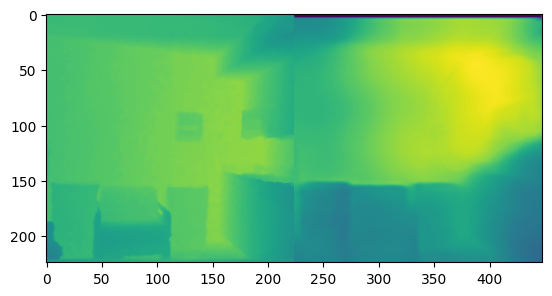

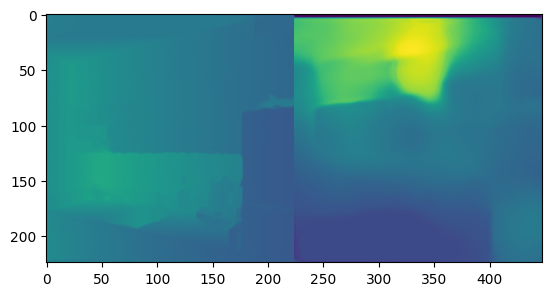

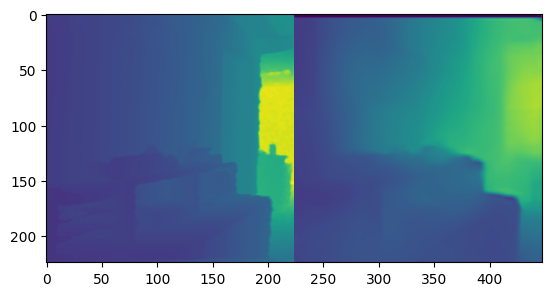

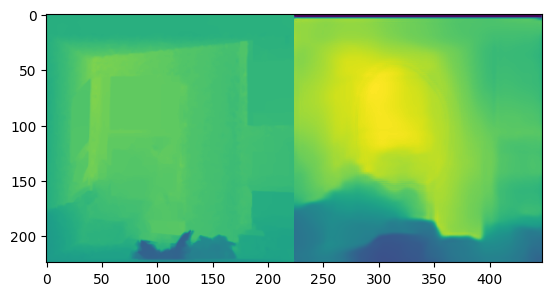

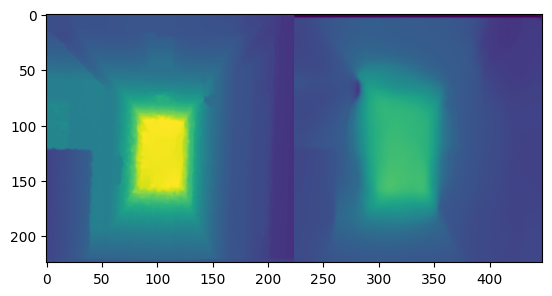

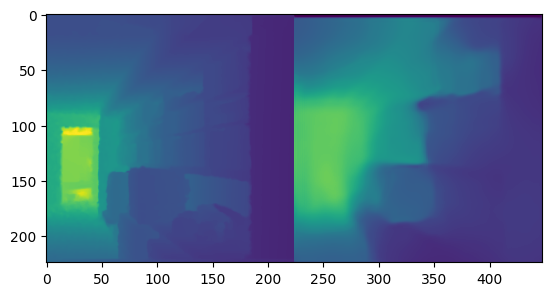

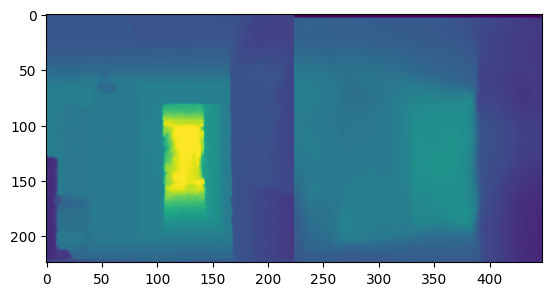

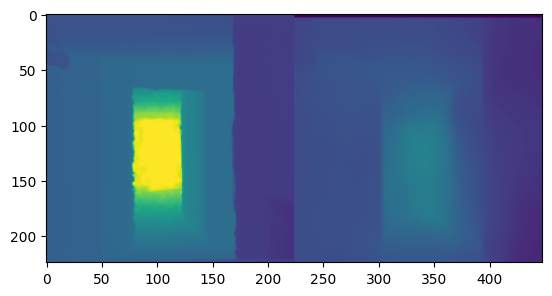

In [28]:
for i in range(8):
    sample_image, sample_ground_truth = sample_batch['image'][i], sample_batch['depth_map'][i]
    plt.imshow(np.hstack([np.asarray(sample_ground_truth).squeeze(), np.asarray(y_hat[i]).squeeze()]))
    plt.show()

### Interpretation of results

For such a simple network with a mobilenet-v2 backbone I find the results quite good. The rough shapes are in most cases clearly visible and correlate with the ground-truth. It's far from the latest results (e.g. Depth Anything mentioned in part 3) but better than anything possible even 15 years ago.

There are of course tons of improvements that could be done, even with this setup (and none of the latest models):
* better backbone network
* more data augmentation
* higher-resolution training data
* using the entire dataset (this exemplary training has been performed on a small subset)
* testing different hyper-parameters

This is a RMSE graph of different training runs. Clearly visible is the improvement with version 28 and 32 where the issue with random crop got resolved. The numbers are so high because each *Trainer* creation leads to an increment, even if no training happened or it was stopped immediately or the trainer got started with arguments to quickly see whether a training run would work.

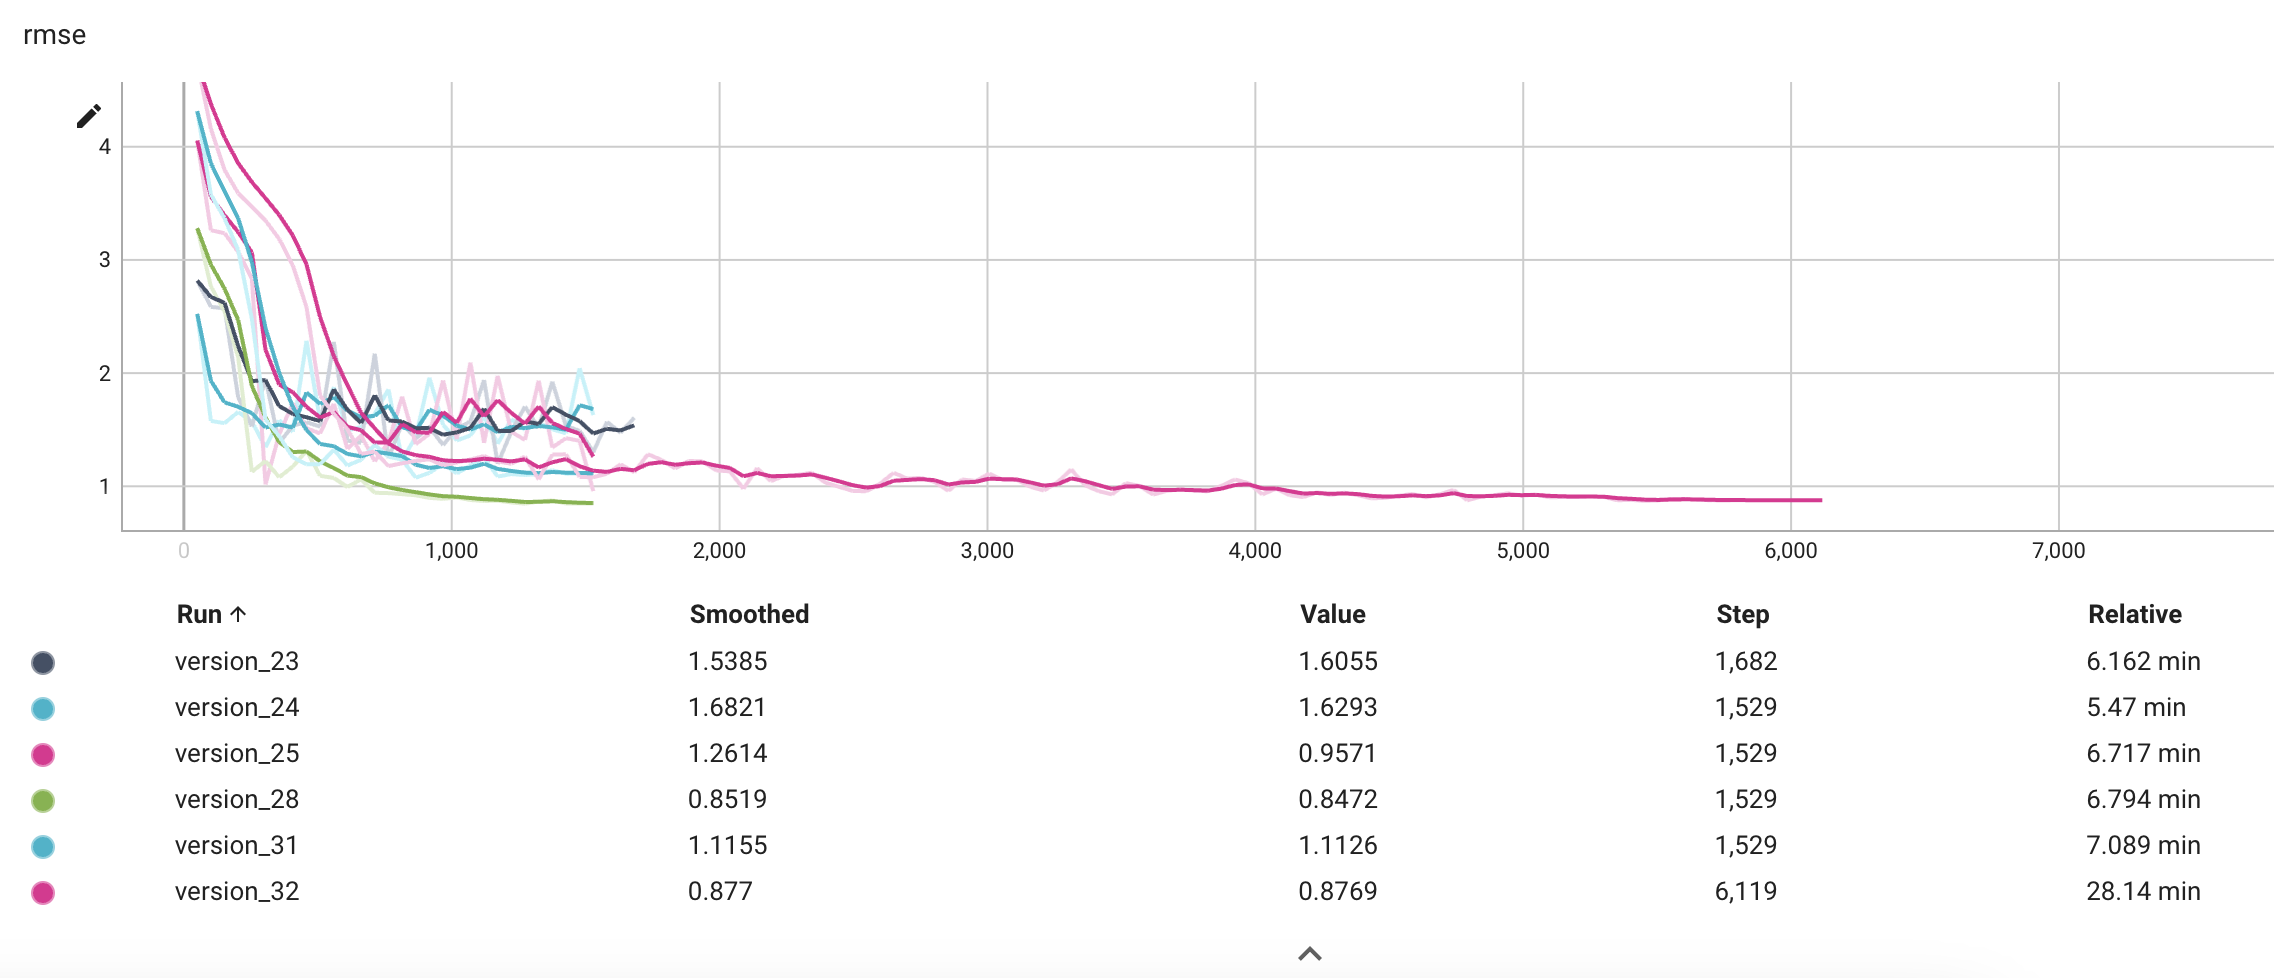